In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Requirement 2 

In [12]:
class NonStationaryEnvironment:
    def __init__(self, num_days, price_levels, num_competitors=3):
        self.num_days = num_days
        self.price_levels = price_levels
        self.num_competitors = num_competitors
        self.bids = np.zeros((num_days, num_competitors))
        self.buying_probabilities = np.zeros((num_days, len(price_levels)))
        self._generate_environment()
        self.m_t = 0

    def _generate_environment(self):
        for t in range(self.num_days):
            if t % 1000 == 0:  # Change the bids and buying probabilities periodically
                self.bids[t:] = np.random.rand(self.num_competitors)
                self.buying_probabilities[t:] = np.random.rand(len(self.price_levels))

    def auction(self, bid, day):
        competing_bids = self.bids[day]
        self.m_t = np.max(competing_bids)
        return bid > self.m_t

    def purchase(self, price, day):
        price_index = np.searchsorted(self.price_levels, price)
        purchase_probability = self.buying_probabilities[day, price_index]
        return np.random.rand() < purchase_probability


In [13]:
# Agent EXP3 with Primal-Dual adjustments
class EXP3AgentPrimalDual:
    def __init__(self, possible_bids, num_prices, learning_rate, budget, eta, T):
        self.num_prices = num_prices
        self.possible_bids = possible_bids

        self.learning_rate = learning_rate
        self.budget = budget
        self.remaining_budget = self.budget
        self.eta = eta
        self.rho = self.budget/T
        
        # Initialize weights for both bids and prices
        self.bid_weights = np.ones(len(possible_bids))
        self.price_weights = np.ones(num_prices)
        
        self.bid_probabilities = self.bid_weights / self.bid_weights.sum()
        self.price_probabilities = self.price_weights / self.price_weights.sum()
        
        # Initialize lambda (pacing multiplier)
        self.lmbd = 1.0
        self.current_day = 0
        self.T = T

        self.last_prob = None

    def choose_bid(self):
        if self.current_day >= self.T:
            return 0
        
        remaining_rounds = self.T - self.current_day
        per_round_budget = self.remaining_budget / remaining_rounds

        epsilon = 1e-10
        probs = (self.bid_weights + epsilon) / np.sum(self.bid_weights + epsilon)
        probs /= np.sum(probs)

        # Adjust probabilities based on budget constraint
        adjusted_probs = np.where(self.possible_bids <= per_round_budget, probs, 0)
        adjusted_probs /= np.sum(adjusted_probs)

        self.last_prob = adjusted_probs
        
        chosen_bid_index = np.random.choice(len(self.possible_bids), p=adjusted_probs)
        chosen_bid = self.possible_bids[chosen_bid_index]

        return chosen_bid

    def update(self, utility, cost):
        # Update weights
        loss = self.lmbd * (cost - self.rho) - utility
        estimated_loss = loss / (self.last_prob + 1e-10)  # Add small constant to avoid division by zero
        
        # Clip the estimated loss to prevent extreme values
        clipped_loss = np.clip(estimated_loss, -10, 10)
        
        # Update weights using softmax to maintain numerical stability
        self.bid_weights = np.exp(np.log(self.bid_weights) - self.eta * clipped_loss)
        self.bid_weights /= np.sum(self.bid_weights)  

        # Update lambda
        self.lmbd = max(0, self.lmbd + self.eta * (cost - self.rho))

        self.remaining_budget -= cost
        self.current_day += 1

    def choose_price(self):
        self.price_probabilities = (1 - self.learning_rate) * (self.price_weights / self.price_weights.sum()) + \
                                   (self.learning_rate / self.num_prices)
        price_level = np.random.choice(self.num_prices, p=self.price_probabilities)
        return price_level

    def update_price(self, price_level, reward):
        estimated_reward = reward / self.price_probabilities[price_level]
        self.price_weights[price_level] *= np.exp(self.learning_rate * estimated_reward / self.num_prices)

In [14]:
def run_interaction(num_days, possible_bids, price_levels, learning_rate, price_change_interval, budget, eta):
    environment = NonStationaryEnvironment(num_days, price_levels)
    agent = EXP3AgentPrimalDual(possible_bids, len(price_levels), learning_rate, budget, eta, num_days)
    cumulative_regret = np.zeros(num_days)
    cumulative_successes = np.zeros(num_days)
    bids = np.array([])
    prices = np.array([])
    total_wins = 0

    np.random.seed(18)  # for experiment reproducibility purposes
    for day in range(num_days):
        # Choose a bid and price
        bid = agent.choose_bid()

        if day % price_change_interval == 0:
            price_level = agent.choose_price()
        price = price_levels[price_level]

        # Run the auction
        won_slot = environment.auction(bid, day)
        if won_slot:
            success = environment.purchase(price, day)
            f_t = price * success  # Utility is the revenue
            c_t = bid  # Cost is the bid
            total_wins += 1
        else:
            f_t = 0
            c_t = 0

        # Update the agent based on the result
        agent.update(f_t, c_t)
        agent.update_price(price_level, f_t)

        # Logging
        cumulative_regret[day] = -f_t
        cumulative_successes[day] = f_t
        bids = np.append(bids, bid)
        prices = np.append(prices, price)

    print(f'Total # of Wins: {total_wins}')
    return cumulative_regret.cumsum(), cumulative_successes.cumsum(), agent, bids, prices


Total # of Wins: 1678


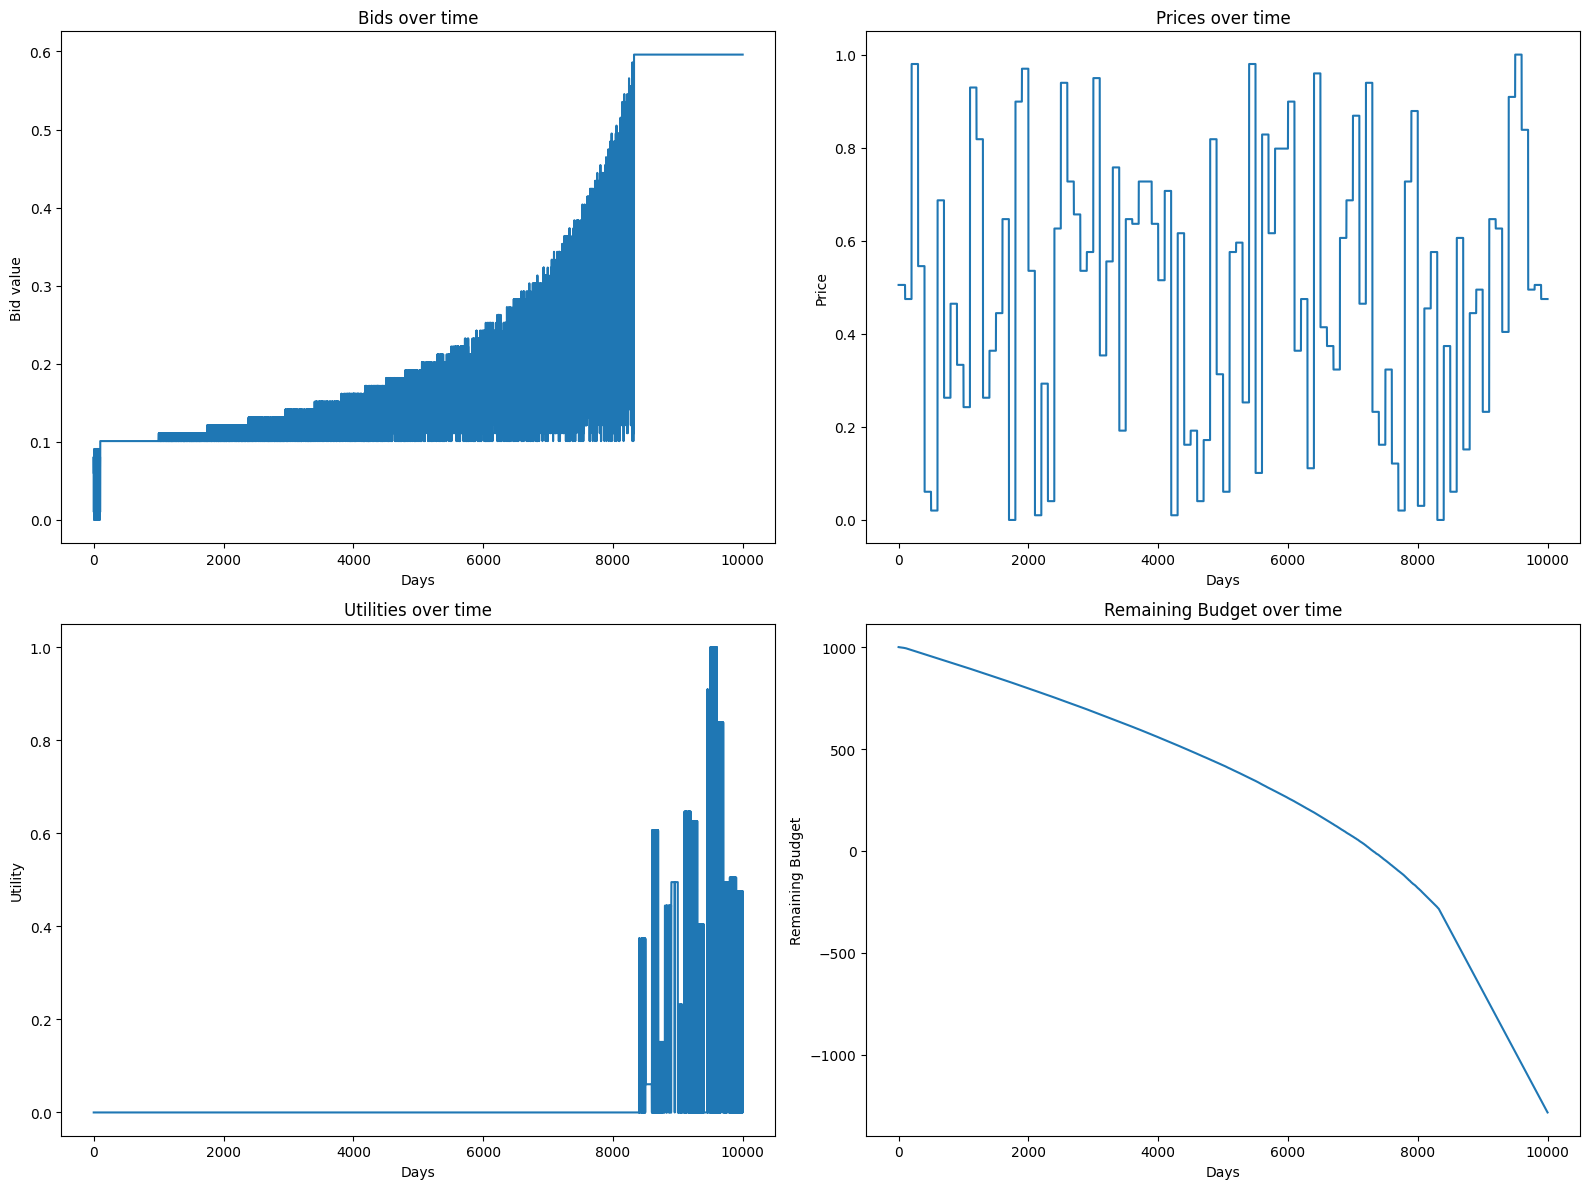

In [15]:
# Parameters
num_days = 10000
price_levels = np.linspace(0, 1, 100)
learning_rate = np.sqrt(np.log(len(price_levels)) / (len(price_levels) * num_days))
price_change_interval = 100
budget = 1000
eta = 0.1

n_bids = 100
bids =  np.linspace(0, 1, n_bids)
# Execution of the interaction
cumulative_regret, cumulative_successes, agent, bids, prices = run_interaction(
    num_days, bids, price_levels, learning_rate, price_change_interval, budget, eta)

# Calculate utilities and remaining budget
utilities = np.diff(cumulative_successes, prepend=0)
remaining_budget = budget - np.cumsum(bids)

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

axs[0, 0].plot(bids)
axs[0, 0].set_title('Bids over time')
axs[0, 0].set_xlabel('Days')
axs[0, 0].set_ylabel('Bid value')

axs[0, 1].plot(prices)
axs[0, 1].set_title('Prices over time')
axs[0, 1].set_xlabel('Days')
axs[0, 1].set_ylabel('Price')

axs[1, 0].plot(utilities)
axs[1, 0].set_title('Utilities over time')
axs[1, 0].set_xlabel('Days')
axs[1, 0].set_ylabel('Utility')

axs[1, 1].plot(remaining_budget)
axs[1, 1].set_title('Remaining Budget over time')
axs[1, 1].set_xlabel('Days')
axs[1, 1].set_ylabel('Remaining Budget')

plt.tight_layout()
plt.show()

In [16]:
from scipy.optimize import minimize

def compute_clairvoyant_strategy(duration, bid_space, max_competitor_bid, own_valuation, budget_constraint):
    win_rates = [sum(bid > max_competitor_bid) / duration for bid in bid_space]
    
    def objective(strategy):
        return sum((own_valuation - bid) * rate * prob for bid, rate, prob in zip(bid_space, win_rates, strategy))
    
    constraints = [
        {'type': 'eq', 'fun': lambda s: sum(s) - 1},
        {'type': 'ineq', 'fun': lambda s: budget_constraint - sum(bid * rate * prob for bid, rate, prob in zip(bid_space, win_rates, s))}
    ]
    
    result = minimize(lambda s: -objective(s), 
                      x0=[1/len(bid_space)] * len(bid_space),
                      method='SLSQP',
                      constraints=constraints,
                      bounds=[(0, 1) for _ in range(len(bid_space))])
    
    optimal_strategy = result.x
    expected_utility = objective(optimal_strategy)
    
    clairvoyant_utilities = [expected_utility] * duration
    clairvoyant_bids = [sum(bid * prob for bid, prob in zip(bid_space, optimal_strategy))] * duration
    
    return clairvoyant_utilities, clairvoyant_bids

In [17]:
def get_clairvoyant_non_truthful(B, my_valuation, m_t, n_users):
    # Calculate utility for each possible bid
    possible_bids = np.linspace(0, 1, 100)  # Discretize bid space
    utilities = np.zeros((n_users, len(possible_bids)))
    for i, bid in enumerate(possible_bids):
        utilities[:, i] = (my_valuation - bid) * (bid > m_t)

    # Find optimal bids greedily
    sorted_round_utility = np.flip(np.argsort(utilities.max(axis=1)))
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids = np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0  # total money spent
    i = 0  # index over the auctions

    while c <= B - 1e-6 and i < n_users:
        round_idx = sorted_round_utility[i]
        best_bid_idx = np.argmax(utilities[round_idx])
        best_bid = possible_bids[best_bid_idx]
        
        if c + best_bid <= B:
            clairvoyant_bids[round_idx] = best_bid
            clairvoyant_utilities[round_idx] = utilities[round_idx, best_bid_idx]
            clairvoyant_payments[round_idx] = best_bid
            c += best_bid
        i += 1

    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

In [18]:
from scipy import optimize

def get_clairvoyant_non_truthful(num_rounds, bid_space, max_competitor_bids, own_valuation, budget_per_round):
    # Calculate win probabilities
    win_rates = [np.mean(bid > max_competitor_bids) for bid in bid_space]
    
    # Set up the linear programming problem
    objective = lambda strategy: -sum((own_valuation - bid) * rate * prob 
                                      for bid, rate, prob in zip(bid_space, win_rates, strategy))
    
    constraints = [
        {'type': 'eq', 'fun': lambda s: sum(s) - 1},
        {'type': 'ineq', 'fun': lambda s: budget_per_round - sum(bid * rate * prob 
                                                                 for bid, rate, prob in zip(bid_space, win_rates, s))}
    ]
    
    # Solve the linear program
    initial_guess = [1/len(bid_space)] * len(bid_space)
    result = optimize.minimize(objective, x0=initial_guess, method='SLSQP', 
                               constraints=constraints, bounds=[(0, 1) for _ in bid_space])
    
    optimal_strategy = result.x
    expected_utility = -result.fun
    
    # Generate results
    clairvoyant_utilities = [expected_utility] * num_rounds
    clairvoyant_bids = [sum(bid * prob for bid, prob in zip(bid_space, optimal_strategy))] * num_rounds
    
    return clairvoyant_utilities, clairvoyant_bids

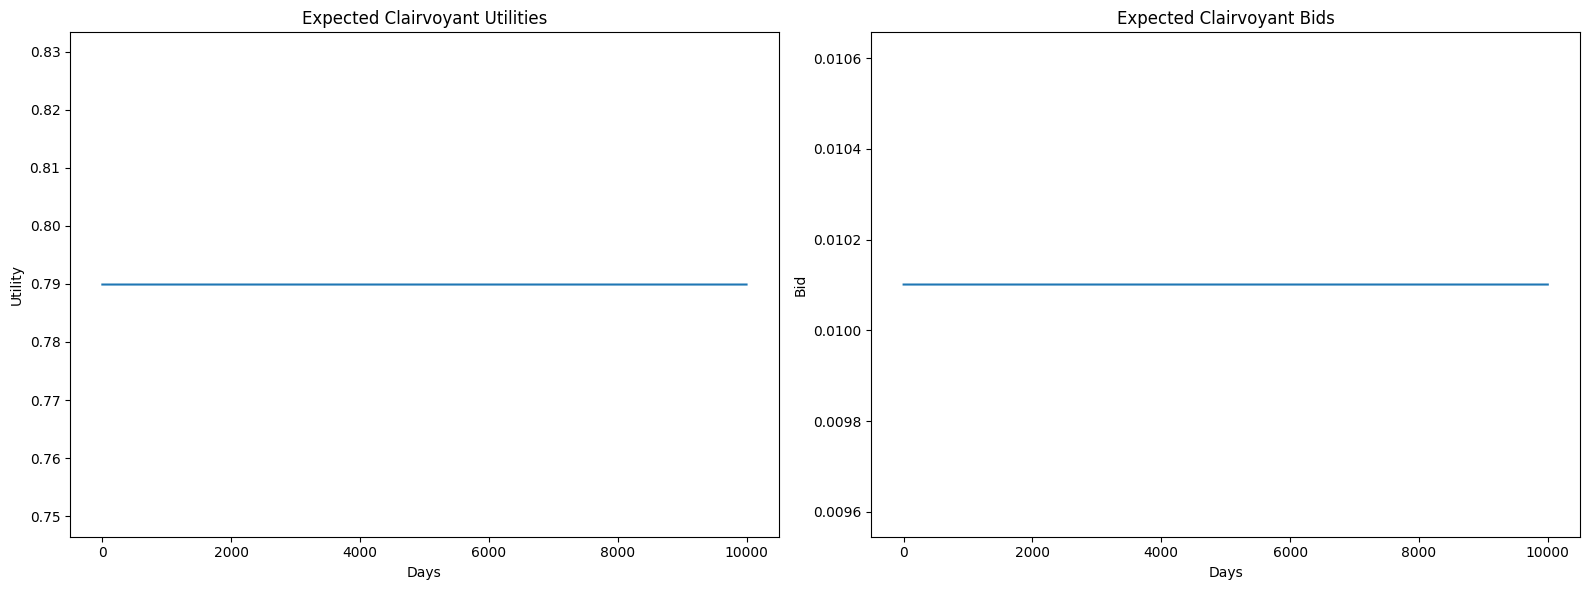

Total expected utility of the clairvoyant algorithm: 7898.99


In [19]:
rho = budget/num_days
n_bids = 100
bids = np.linspace(0, 1, n_bids)
environment = NonStationaryEnvironment(num_days, price_levels)

# Get the maximum competitor bid for each day
m_t_array = np.array([environment.m_t for _ in range(num_days)])

# Assume a constant valuation (you may want to adjust this)
my_valuation = 0.8

# Run the clairvoyant algorithm
clairvoyant_utilities, clairvoyant_bids = get_clairvoyant_non_truthful(num_days, bids, m_t_array, my_valuation, rho)

# Plot the expected clairvoyant utilities and bids
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(clairvoyant_utilities)
axs[0].set_title('Expected Clairvoyant Utilities')
axs[0].set_xlabel('Days')
axs[0].set_ylabel('Utility')

axs[1].plot(clairvoyant_bids)
axs[1].set_title('Expected Clairvoyant Bids')
axs[1].set_xlabel('Days')
axs[1].set_ylabel('Bid')

plt.tight_layout()
plt.show()

# Calculate and print the total expected utility
total_expected_utility = sum(clairvoyant_utilities)
print(f"Total expected utility of the clairvoyant algorithm: {total_expected_utility:.2f}")

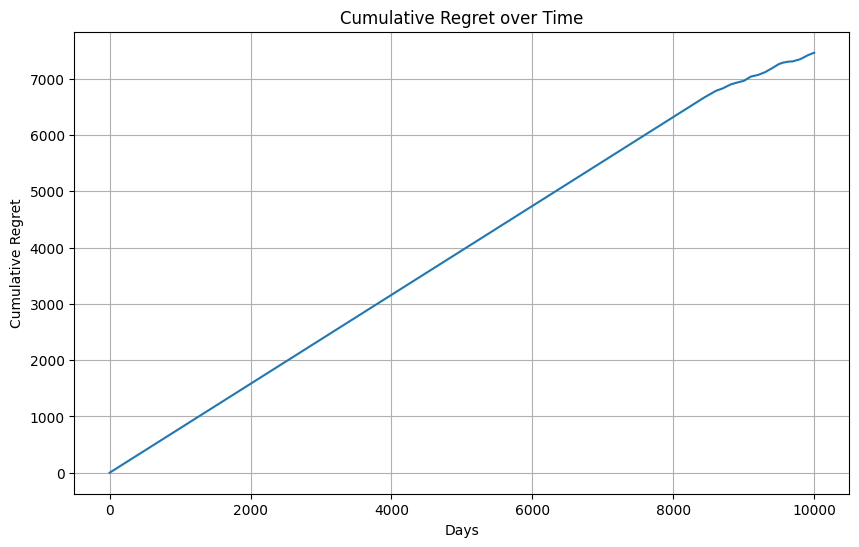

In [20]:
# Compute cumulative regret
cumulative_regret = np.cumsum(np.array(clairvoyant_utilities) - utilities)

# Plot cumulative regret
plt.figure(figsize=(10, 6))
plt.plot(cumulative_regret)
plt.title('Cumulative Regret over Time')
plt.xlabel('Days')
plt.ylabel('Cumulative Regret')
plt.grid(True)
plt.show()
